### Series Introduction:

Welcome to the **Kaggle Customer Churn Master Series**, where we've journeyed through the essentials and beyond in predicting customer churn.If you are unaware about this series please take a look into first two notebooks . Throughout this series, we've explored data analysis, feature engineering, and model optimization to equip you with the tools and knowledge to tackle churn prediction with confidence. 

### Notebook Introduction:

In **Notebook 3**, the final installment of this series, we bring everything together with a focus on model tracking and deployment. Using **MLflow** and **DagsHub**, we track experiments and visualize results to fine-tune our models to perfection. This notebook showcases the final steps in refining our predictions, ensuring that our churn model is both accurate and ready for real-world application.


# 🚨 **Warning: You're Missing Out!** 🚨 

If you've jumped straight into this notebook, you're skipping some crucial steps that could significantly impact your understanding of MLflow. In the previous notebook, we laid the foundation for everything we're about to do here.


### **Why the Previous Notebook Matters**

In the previous notebook, we covered foundational concepts related to **model optimization** and **feature engineering**. These are not just technical details—they are pivotal for managing machine learning workflows effectively.**```Feature Engineering is the most important phase of ML cycle. ```** Indeed, I have reproduced most of the code from the priviouse notebook.  Missing this part means missing out on critical techniques and the context necessary for fully grasping the advanced concepts we’ll explore here.

[**Go back to the previous notebook now!**](https://www.kaggle.com/code/deepsutariya/churn-prediction-featuretools-optuna-mastery)



### Navigation:

- **Previous Notebook:** [Churn Prediction Featuretools Optuna Mastery](https://www.kaggle.com/code/deepsutariya/churn-prediction-featuretools-optuna-mastery)

---

### Series Navigation:

- **First Notebook:** [Explore Churn Insights: Plotly EDA for Beginners](https://www.kaggle.com/code/deepsutariya/explore-churn-insights-plotly-eda-for-beginners)
- **Second Notebook:** [Churn Prediction Featuretools Optuna Mastery](https://www.kaggle.com/code/deepsutariya/churn-prediction-featuretools-optuna-mastery)
- **Third Notebook:** [Churn Modeling to Deployment: MLflow & DagsHub](https://www.kaggle.com/code/deepsutariya/churn-modeling-to-deployment-mlflow-DagsHub)


In [4]:
# %pip install dagshub mlflow


  Using cached dagshub-0.3.35-py3-none-any.whl.metadata (11 kB)
  Using cached httpx-0.23.3-py3-none-any.whl.metadata (7.1 kB)
  Using cached dagshub_annotation_converter-0.1.0-py3-none-any.whl.metadata (2.5 kB)
  Using cached s3transfer-0.10.2-py3-none-any.whl.metadata (1.7 kB)
Using cached dagshub-0.3.35-py3-none-any.whl (247 kB)
Using cached dagshub_annotation_converter-0.1.0-py3-none-any.whl (30 kB)
Using cached httpx-0.23.3-py3-none-any.whl (71 kB)
   ---------------------------------------- 0.0/12.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.5 MB ? eta -:--:--
    --------------------------------------- 0.3/12.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.5 MB 799.2 kB/s eta 0:00:15
   - -------------------------------------

In [5]:
import optuna
import mlflow
import warnings
import shutil
import re
import os
import zipfile
import subprocess
import uuid
import dagshub
import lightgbm as lgb
import mlflow.lightgbm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import matplotlib.image as mpimg
from IPython.display import FileLink,display,Image
from mlflow.tracking import MlflowClient
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder,StandardScaler , OrdinalEncoder 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score,recall_score,precision_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

In [8]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'tnbmarketplace'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '0d957e7b20c38643e8fd8de6d9d8e1de130caf90'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/tnbmarketplace/mlflow_experiment_tracking.mlflow'
os.environ['DAGSHUB_USER_TOKEN'] = "fc957a0e9846b45be51bcea1a3ea28f7a3f236aa"
!dagshub login --token "fc957a0e9846b45be51bcea1a3ea28f7a3f236aa"

✅ Token added successfully


In [9]:
dagshub.init(repo_name='mlflow_experiment_tracking',repo_owner='tnbmarketplace',mlflow=True)

Accessing as tnbmarketplace

Initialized MLflow to track repo "tnbmarketplace/mlflow_experiment_tracking"

Repository tnbmarketplace/mlflow_experiment_tracking initialized!

In [10]:
# The below class loads the data and performs basic preprocessing steps

class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path  # Store the file path
        self.df = None  # Initialize an empty DataFrame

    def load_data(self):
        # Load data from the CSV file
        self.df = pd.read_csv(self.file_path)
        
        # Replace the 'SeniorCitizen' column values: 0 -> "No", 1 -> "Yes"
        self.df['SeniorCitizen'] = self.df['SeniorCitizen'].replace({0: "No", 1: "Yes"})
        
        # Convert 'TotalCharges' to numeric, coercing errors to NaN
        self.df['TotalCharges'] = pd.to_numeric(self.df['TotalCharges'], errors='coerce')
        
        # Replace the 'Churn' column values: "Yes" -> 1, "No" -> 0
        self.df['Churn'] = self.df['Churn'].replace({"Yes": 1, "No": 0})
        
        # Drop the 'customerID' column and reset the index
        self.df = self.df.drop('customerID', axis=1).reset_index()
        
        return self.df

    def preprocess_data(self):
        # Create dummy variables for categorical features (excluding 'Churn')
        dummy_df = pd.get_dummies(self.df.drop('Churn', axis=1))
        
        # Add the 'Churn' column back to the dummy DataFrame
        dummy_df['Churn'] = self.df['Churn']
        
        return dummy_df


In [11]:
#load the data
data_loader = DataLoader("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = data_loader.load_data()
encd_df = data_loader.preprocess_data()

In [12]:
# split into train , test ,validation datasets
def split_data(dummy_df):
    train_set, test_set = train_test_split(dummy_df, test_size=0.2, shuffle=True, random_state=42, stratify=dummy_df['Churn'])
    train_set_splitted, val_set = train_test_split(train_set, test_size=0.15, shuffle=True, random_state=42, stratify=train_set['Churn'])
    return train_set, test_set, train_set_splitted, val_set

In [13]:
train_set,test_set,train_set_splitted,val_set = split_data(encd_df.dropna())
X_train , y_train , X_test , y_test = train_set.drop(columns=['Churn','index']) , train_set['Churn'] , test_set.drop(columns=['index','Churn']) , test_set['Churn']
X_train_splitted , y_train_splitted, X_val,y_val = train_set_splitted.drop('Churn',axis = 1 ) , train_set_splitted['Churn'] , val_set.drop('Churn',axis = 1) , val_set['Churn']
X_train_splitted.shape

(4781, 47)

## Understanding the Feature Engineering Code

If you're new to feature engineering or need a quick refresher, here's a breakdown of the code provided. This code is part of a class designed to streamline the process of feature engineering using the **Featuretools** library.

### **Class Overview**

The `Feature_Engineering` class is used to manage and transform datasets for machine learning tasks. It has several key components:

- **Initialization (`__init__`)**: 
  - Sets up the training and test datasets.
  - Initializes placeholders for the entity set and dataset names.

### **Key Methods**

1. **`Create_Entityset`**:
   - **Purpose**: Creates an entity set, which is a data structure used by Featuretools to manage and transform data.
   - **How It Works**:
     - Adds the training and test datasets to the entity set.
     - Allows the option to specify an index column if it exists, or creates a new one.

2. **`__clean_feature_names`**:
   - **Purpose**: Cleans up feature names by replacing special characters with underscores.
   - **How It Works**: Uses regular expressions to ensure that column names are consistent and free from problematic characters.

3. **`__remove_duplicate_columns`**:
   - **Purpose**: Removes duplicate columns from a DataFrame.
   - **How It Works**: Ensures that there are no repeated columns, which can occur during feature engineering.

4. **`Generate_Features`**:
   - **Purpose**: Generates new features for both the training and test datasets.
   - **How It Works**:
     - Uses Featuretools’ `dfs` (Deep Feature Synthesis) function to create new features.
     - Allows customization of transformation and aggregation primitives.
     - Cleans and aligns features to ensure consistency between training and test datasets.
     - Optionally only returns feature names without generating actual feature values.

### **What This Code Achieves**

- **Feature Engineering**: Transforms raw data into meaningful features that improve model performance.
- **Data Alignment**: Ensures that training and test data are aligned, with consistent columns and no duplicates.
- **Data Cleaning**: Addresses issues such as duplicate columns and special characters in feature names, ensuring cleaner and more reliable data.

### **Why This Matters**

Understanding this code is crucial because feature engineering significantly impacts your model's performance. Well-engineered features can lead to better insights and more accurate predictions. Additionally, managing data consistency and cleanliness is fundamental to building robust machine learning models.

By mastering these techniques, you enhance your ability to handle real-world data effectively, making you a more skilled data scientist or machine learning engineer.


In [14]:
class Feature_Engineering:
    def __init__(self, train_set, test_set, df):
        self.train_set = train_set  # Training dataset
        self.test_set = test_set  # Test dataset
        self.entity_set = None  # Placeholder for entity set
        self.train_set_name = None  # Name of training dataset in entity set
        self.test_set_name = None  # Name of test dataset in entity set
        self.df = df  # Original DataFrame

    def Create_Entityset(self, entity_id, train_set_name, test_set_name, index_name=None):
        # Check if index_name is not present in train and test sets
        if index_name not in self.train_set.columns and index_name not in self.test_set.columns:
            es = ft.EntitySet(id=entity_id)
            # Add train_set to the entity set with make_index=True
            es.add_dataframe(
                dataframe_name=train_set_name,
                dataframe=self.train_set, 
                make_index=True,
                index=index_name,
                # time_index='tenure'  # Uncomment if using time index
            ) 
            # Add test_set to the entity set with make_index=True
            es.add_dataframe(
                dataframe_name=test_set_name,
                dataframe=self.test_set,
                make_index=True,
                index=index_name,
                # time_index='tenure'  # Uncomment if using time index
            )
        else:
            es = ft.EntitySet(id=entity_id)
            # Add train_set to the entity set with existing index
            es.add_dataframe(
                dataframe_name=train_set_name,
                dataframe=self.train_set,
                index=index_name,
                # time_index='tenure'  # Uncomment if using time index
            )
            # Add test_set to the entity set with existing index
            es.add_dataframe(
                dataframe_name=test_set_name,
                dataframe=self.test_set,
                index=index_name,
                # time_index='tenure'  # Uncomment if using time index
            )
        self.entity_set = es  # Store the entity set
        self.train_set_name = train_set_name  # Store the training set name
        self.test_set_name = test_set_name  # Store the test set name

    def __clean_feature_names(self, df):
        # Clean column names by replacing special characters with underscore
        cleaned_names = []
        for col in df.columns:
            clean_name = re.sub(r'[^A-Za-z0-9_]+', '_', col)
            cleaned_names.append(clean_name)
        df.columns = cleaned_names
        return df

    def __remove_duplicate_columns(self, df):
        # Remove duplicate columns
        df = df.loc[:, ~df.columns.duplicated()]
        return df

    def Generate_Features(self, trans_list=None, agg_list=None, ignore_columns=None, names_only=True):
        if names_only == False:
            # Generate features for training set
            feature_df, feature_names = ft.dfs(
                entityset=self.entity_set,
                target_dataframe_name=self.train_set_name,
                trans_primitives=trans_list,
                max_depth=2,
                ignore_columns=ignore_columns,
                features_only=names_only,
                ignore_dataframes=[self.test_set_name]
            )
            # Ensure 'index' column in feature_df is treated as integer index
            feature_df = feature_df.reset_index()
            feature_df['index'] = feature_df['index'].astype(int)

            # Align feature_df index to avoid out-of-range or mismatch
            aligned_churn = self.df.loc[feature_df['index'], 'Churn'].reset_index(drop=True)

            # Assign aligned Churn values to feature_df
            feature_df['Churn'] = aligned_churn

            # Generate features for test set
            feature_df_test, features_test_name = ft.dfs(
                entityset=self.entity_set,
                target_dataframe_name=self.test_set_name,
                trans_primitives=trans_list,
                max_depth=2,
                ignore_columns=ignore_columns,
                features_only=names_only,
                ignore_dataframes=[self.train_set_name]
            )
            # Ensure 'index' column in feature_df_test is treated as integer index
            feature_df_test = feature_df_test.reset_index()
            feature_df_test['index'] = feature_df_test['index'].astype(int)

            # Align feature_df_test index to avoid out-of-range or mismatch
            aligned_churn_test = self.df.loc[feature_df_test['index'], 'Churn'].reset_index(drop=True)

            # Assign aligned Churn values to feature_df_test
            feature_df_test['Churn'] = aligned_churn_test

            # Drop 'index' column from feature dataframes
            feature_df = feature_df.drop('index', axis=1)
            feature_df_test = feature_df_test.drop('index', axis=1)

            # Clean feature names for both train and test datasets
            feature_df = self.__clean_feature_names(feature_df)
            feature_df_test = self.__clean_feature_names(feature_df_test)

            # Remove duplicate columns from both datasets
            feature_df = self.__remove_duplicate_columns(feature_df)
            feature_df_test = self.__remove_duplicate_columns(feature_df_test)

            # Remove columns with a single unique value
            single_col_list = [col for col in feature_df.columns if feature_df[col].nunique() == 1]
            feature_df = feature_df.drop(columns=single_col_list)

            # Replace infinite values with NaN
            feature_df = feature_df.replace([-np.inf, np.inf], np.nan)
            feature_df_test = feature_df_test.replace([-np.inf, np.inf], np.nan)

            # Align the datasets to keep only common columns
            featured_train_labels = feature_df['Churn']
            feature_df_aligned, feature_df_test_aligned = feature_df.align(feature_df_test, join='inner', axis=1)
            feature_df_aligned['Churn'] = featured_train_labels

            return feature_df_aligned, feature_df_test_aligned
        else:
            # Generate feature names only for training set
            feature_names = ft.dfs(
                entityset=self.entity_set,
                target_dataframe_name=self.train_set_name,
                trans_primitives=trans_list,
                max_depth=2,
                ignore_columns=ignore_columns,
                features_only=names_only,
                ignore_dataframes=[self.test_set_name]
            )
            # Generate feature names only for test set
            feature_test_names = ft.dfs(
                entityset=self.entity_set,
                target_dataframe_name=self.test_set_name,
                trans_primitives=trans_list,
                max_depth=2,
                ignore_columns=ignore_columns,
                features_only=names_only,
                ignore_dataframes=[self.train_set_name]
            )
            return feature_names, feature_test_names

In [15]:
trans_list =  [
 'multiply_numeric_boolean',
 'absolute_diff',
 'email_address_to_domain',
 'exponential_weighted_variance',
 'modulo_numeric',
 'rate_of_change',
 'url_to_protocol',
 'greater_than',
 'multiply_numeric_scalar',
 'less_than_equal_to',
 'longitude',
 'age',
 'cosine',
 'subtract_numeric',
 'week',
 'cityblock_distance',
 'rolling_max',
 'subtract_numeric_scalar',
 'is_quarter_end',
 'less_than_scalar',
 'exponential_weighted_std',
 'natural_logarithm',
 'add_numeric_scalar',
 'percent_change',
 'subtract_numeric',
 'is_lunch_time'
]


In [16]:
# while feature generating we shouldn't use Churn and index.
# Using Churn will cause data leak
# Index is redundant feature
ignore_columns = {
    'smoted_train':['Churn','index'],
    'val_test':['Churn','index',]
}
val_copy = val_set.copy()

# let's generate features for the splitted_train , val set
ignore_columns = {
    'train':['Churn','index'],
    'test':['Churn','index',]
}
feature_eng = Feature_Engineering(train_set_splitted,val_set,encd_df)
feature_eng.Create_Entityset('validation','train','test','index')

# the below sets will be used for the training and validation process
featured_train_set , featured_val_set = feature_eng.Generate_Features(trans_list,ignore_columns = ignore_columns , names_only=False)


# below code generate the features for the final_train , test set
ignore_columns = {
    'final_train':['Churn','index'],
    'final_test':['Churn','index',]
}
feature_eng = Feature_Engineering(train_set,test_set,encd_df)
feature_eng.Create_Entityset('final','final_train','final_test','index')
 
# the below sets will be used for the train and test the final model that we will get from the val set
featured_final_train_set , featured_test_set = feature_eng.Generate_Features(trans_list,ignore_columns = ignore_columns , names_only=False)


2024-08-28 07:09:19,968 featuretools - WARNING    Attempting to add feature <Feature: MonthlyCharges - TotalCharges> which is already present. This is likely a bug.
2024-08-28 07:09:19,969 featuretools - WARNING    Attempting to add feature <Feature: MonthlyCharges - tenure> which is already present. This is likely a bug.
2024-08-28 07:09:19,970 featuretools - WARNING    Attempting to add feature <Feature: tenure - TotalCharges> which is already present. This is likely a bug.
2024-08-28 07:09:20,827 featuretools - WARNING    Attempting to add feature <Feature: MonthlyCharges - TotalCharges> which is already present. This is likely a bug.
2024-08-28 07:09:20,828 featuretools - WARNING    Attempting to add feature <Feature: MonthlyCharges - tenure> which is already present. This is likely a bug.
2024-08-28 07:09:20,828 featuretools - WARNING    Attempting to add feature <Feature: tenure - TotalCharges> which is already present. This is likely a bug.
2024-08-28 07:09:21,629 featuretools -

In [17]:
class FeatureTransformer:
    def __init__(self, train_set, test_set):
        self.train_set = train_set  # Training dataset
        self.test_set = test_set  # Test dataset

        # Lists to store numerical and categorical feature names
        self.num_list = [col for col in train_set.columns if train_set[col].dtype != 'bool']
        self.cat_list = [col for col in train_set.columns if train_set[col].dtype == 'bool']
        
        self.num_list.remove('Churn')  # Remove the target variable from numerical features

        # Define the column transformer
        self.col_transfm = ColumnTransformer(
            transformers=[
                # Pipeline for numerical features: imputation and scaling
                ("num", Pipeline(
                    steps=[
                        ("imputer", SimpleImputer(strategy='median')),  # Impute missing values with median
                        ("scaler", StandardScaler())  # Standardize numerical features
                    ]), self.num_list)
            ],
            n_jobs=-1,  # Use all available cores
            verbose=True,  # Verbose output
            verbose_feature_names_out=True,  # Verbose feature names
            remainder='passthrough'  # Keep remaining columns as they are
        )

    def transform(self):
        # Fit and transform the training set
        self.train_set = self.col_transfm.fit_transform(self.train_set)
        # Transform the test set
        self.test_set = self.col_transfm.transform(self.test_set)

        # Convert transformed data to DataFrames with feature names
        self.train_set = pd.DataFrame(self.train_set, columns=self.col_transfm.get_feature_names_out())
        self.test_set = pd.DataFrame(self.test_set, columns=self.col_transfm.get_feature_names_out())

        # Rename the Churn column
        self.train_set = self.train_set.rename(columns={'remainder__Churn': 'Churn'})
        self.test_set = self.test_set.rename(columns={'remainder__Churn': 'Churn'})

        # Ensure all data is of type float64
        self.train_set, self.test_set = self.train_set.astype('float64'), self.test_set.astype('float64')

        return self.train_set, self.test_set  # Return the transformed datasets


In [18]:
# Apply the feature engineering pipeline to the training and validation sets
# - Fit and transform the training set using the pipeline
# - Transform the validation set using the pipeline
# - Ensure that the same transformations are applied to both sets

feature_transformer = FeatureTransformer(featured_train_set,featured_val_set)
transformed_featured_train_set , transformed_featured_val_set = feature_transformer.transform()

In [19]:
# transforming final train set and test set
feature_transformer = FeatureTransformer(featured_final_train_set,featured_test_set)
transformed_featured_final_train_set , transformed_featured_test_set = feature_transformer.transform()


### Optimization

## Why Model Tuning is Crucial and How Optuna Helps

In the world of machine learning, model tuning is a critical step that can significantly impact your model's performance. Whether you’re working on a startup project or a large-scale production system, finding the optimal hyperparameters can make the difference between a mediocre model and one that excels at solving real-world problems.

### **The Importance of Model Tuning**

Model tuning involves adjusting various hyperparameters to find the best combination for your machine learning model. This process is essential because:

- **Enhanced Performance**: Proper tuning ensures that your model performs at its best, leading to better predictions and more accurate results.
- **Efficient Use of Resources**: Fine-tuning your model can lead to more efficient use of computational resources, saving time and cost in the long run.
- **Real-World Impact**: For companies and startups dealing with real-world data, optimized models can lead to actionable insights and improved decision-making.

### **How Optuna Facilitates Effective Tuning**

**Optuna** is an open-source hyperparameter optimization framework that simplifies and automates the model tuning process. Here’s how it works:

- **Automatic Search**: Optuna employs advanced optimization algorithms to automatically search for the best hyperparameter values. This helps in discovering optimal configurations without extensive manual intervention.
- **Efficient Trials**: By intelligently exploring different hyperparameter combinations, Optuna reduces the number of trials needed to find a high-performing model.
- **Scalable Optimization**: Suitable for both small-scale experiments and large production systems, Optuna can handle complex tuning tasks with ease.

### **The Power of Experiment Logging with MLflow**

Logging experiments is a crucial practice for tracking and managing machine learning experiments effectively. **MLflow** stands out as a powerful tool in this area, offering several benefits:

- **Comprehensive Tracking**: MLflow logs every aspect of your experiments, including hyperparameters, metrics, and artifacts. This comprehensive tracking allows you to revisit and compare past experiments easily.
- **Seamless Integration**: With MLflow, you can integrate experiment tracking into your workflow effortlessly. This is especially useful for startups and companies that need to maintain a robust and reproducible process for model development.
- **Production Readiness**: MLflow's capabilities extend to managing experiments in production environments, ensuring that your models are well-documented and easily accessible.

### **How MLflow Can Help**

In the provided code, **MLflow** is used to manage experiments and log important metrics and model artifacts. Here’s a brief overview of the process:

1. **Setup**: MLflow is configured with a tracking URI, directing where experiments will be logged.
   
2. **Logging Parameters and Metrics**: During each trial of the hyperparameter optimization process, parameters and metrics are logged using `mlflow.log_param` and `mlflow.log_metric`. This allows you to monitor how different parameter choices affect model performance.

3. **Model Artifacts**: The trained model is saved and logged as an artifact, making it easy to access and deploy later.

4. **Experiment Management**: MLflow’s UI enables you to view and compare different experiments, providing insights into how various configurations impact model performance.

By leveraging Optuna for tuning and MLflow for logging, you ensure that your machine learning process is both efficient and well-documented. This combination of tools not only enhances model performance but also improves the overall manageability and reproducibility of your experiments.

---

For a more detailed look at how these tools are implemented in practice, check out the code examples and explanations in the notebook!


In [20]:
mlflow.set_tracking_uri("https://dagshub.com/tnbmarketplace/mlflow_experiment_tracking.mlflow")

**If you want to run trials make the below variable True.**

In [21]:
run_trials = False

### Overview

The `objective` function is an integral part of the Optuna optimization process, designed to tune the hyperparameters of a LightGBM model. This function achieves the following:

1. **Setup for MLflow**: Initializes MLflow logging to manually track experiment parameters and metrics, overriding LightGBM's automatic logging.
2. **Hyperparameter Definition**: Uses Optuna to suggest and define a range of hyperparameters for the LightGBM model. These include learning rate, number of leaves, and regularization parameters.
3. **Model Training**: Trains the LightGBM model with the suggested hyperparameters on the training dataset and evaluates its performance on a validation dataset.
4. **Evaluation and Metrics**: Calculates performance metrics such as AUC, recall, precision, F1 score, weighted recall, and accuracy, logging these metrics to MLflow.
5. **Artifact Logging**: Saves the trained model and logs it as an artifact in MLflow, along with the hyperparameters and metrics.
6. **Error Handling**: Catches and prints exceptions if any issues arise during the training or logging process.

This structured approach helps in systematically optimizing model performance while keeping track of all relevant details, making it suitable for production environments and real-world applications.


In [22]:
def objective(trial):
    try:
        # Disable auto-logging for LightGBM in MLflow (manual logging is used)
        mlflow.lightgbm.autolog(disable=True)
        
        # Create a new MLflow run for this trial
        run = client.create_run(experiment.experiment_id)
        print(f"Starting trial {trial.number} with run ID: {run.info.run_id}")

        # Define hyperparameters for LightGBM, using Optuna suggestions
        param = {
            'objective': 'binary',
            'metric': 'auc',
            'verbose': -1,
            'boosting_type': 'gbdt',
            'scale_pos_weight': 3,
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 1e-1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 150),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'early_stopping_round': 200,
            'num_boost_rounds': 3000
        }

        # Log each hyperparameter to MLflow
        for key, value in param.items():
            client.log_param(run.info.run_id, key, value)

        # Prepare LightGBM datasets for training and validation
        dtrain = lgb.Dataset(transformed_featured_train_set.drop(columns='Churn'), label=transformed_featured_train_set['Churn'])
        dtest = lgb.Dataset(transformed_featured_val_set.drop(columns='Churn'), label=transformed_featured_val_set['Churn'])

        # Train the LightGBM model with the specified parameters
        model = lgb.train(param, dtrain, 3000, [dtest])

        # Make predictions and evaluate the model
        preds = model.predict(transformed_featured_val_set.drop(columns='Churn'))
        preds_digits = [0 if pred < 0.4 else 1 for pred in preds]
        y_true = transformed_featured_val_set['Churn']

        # Compute various performance metrics
        auc = roc_auc_score(y_true, preds)
        recall = recall_score(y_true, preds_digits)
        precision = precision_score(y_true, preds_digits)
        f1 = f1_score(y_true, preds_digits)
        weighted_recall = 0.6 * recall + 0.4 * f1
        accuracy = accuracy_score(y_true, preds_digits)

        # Log the performance metrics to MLflow
        metrics = {
            'auc': auc,
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'weighted_recall': weighted_recall,
            'accuracy': accuracy
        }

        for key, value in metrics.items():
            client.log_metric(run.info.run_id, key, value)

        # Create a directory to save the model for this trial
        trial_id = f"trial_{trial.number}"
        trial_dir = os.path.join('/kaggle/working/experiments', trial_id)
        os.makedirs(trial_dir, exist_ok=True)

        # Save the trained model to a file and log it to MLflow
        model_path = os.path.join(trial_dir, 'artifacts', 'model.txt')
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        model.save_model(model_path)
        
        trial.set_user_attr("model", model)
        
        client.log_artifact(run.info.run_id, model_path)

    except Exception as e:
        # Print error message and return a low score if an exception occurs
        print(f"Trial {trial.number} failed: {e}")
        return 0.0

    # Return the weighted recall as the objective value for Optuna
    return weighted_recall

### **Visualizing Experiments on MLflow UI**

1. Copy your experiment name as indicated in below image. If you are not running trials you can use my experiment(name = my experiment).




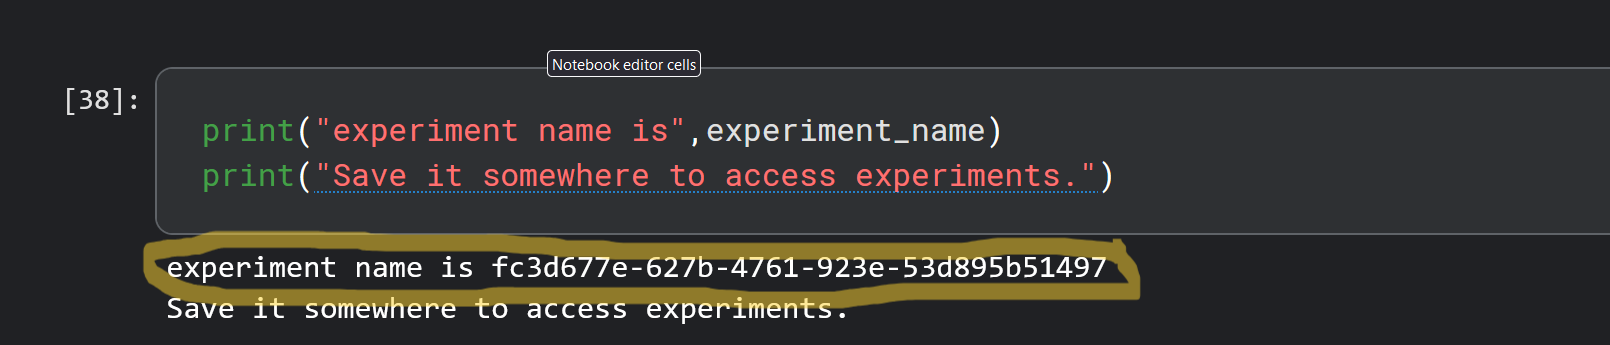

In [23]:
display(Image(r"../reports/figures/Screenshot (154).png"))

2. Go to the by clicking here https://dagshub.com/tnbmarketplace/mlflow_experiment_tracking.mlflow 

3. paste your experiment name in serach bar and search it then click on the your experiment as shown below image. If you want to run experiment done by me write my experiment in the name of the search bar and click on it.

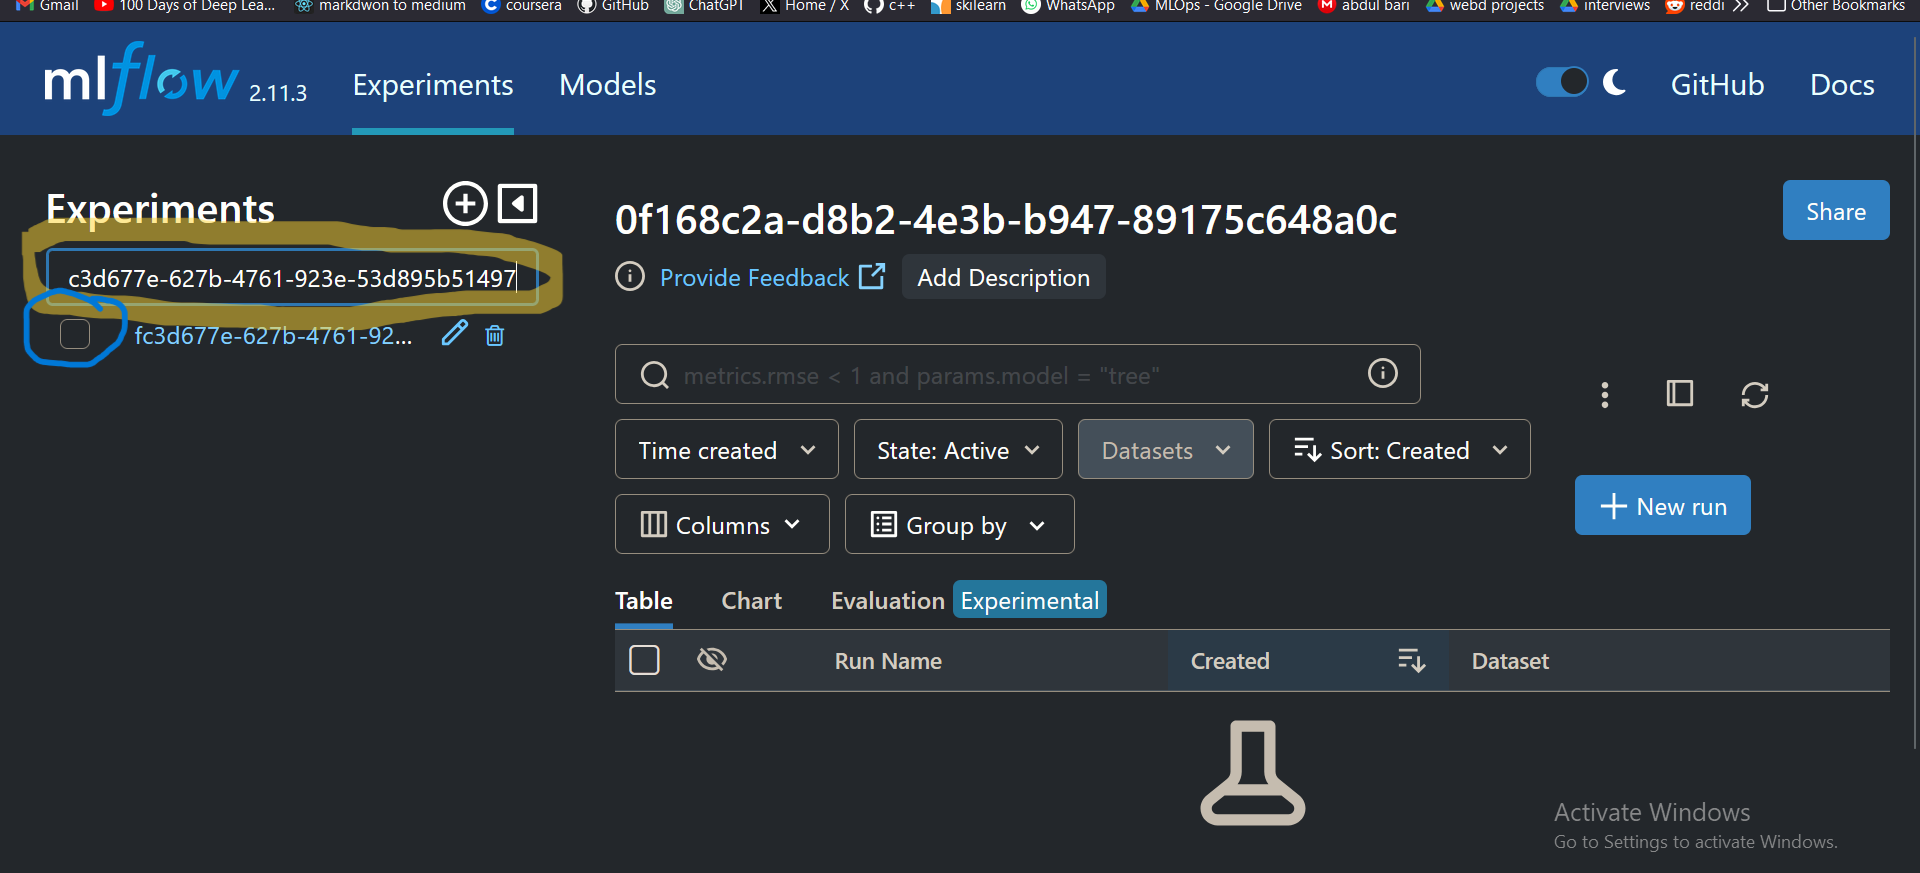

In [25]:
display(Image(r"../reports/figures/Screenshot (155).png"))

In [27]:
if run_trials:

    # Initialize MLflow Client
    client = MlflowClient()

    # Define your experiment (use an existing one or create a new one)
    experiment_name =  str(uuid.uuid4())
#     experiment_name ="my experiment"
    
    try:
        # Attempt to create a new experiment
        experiment_id = client.create_experiment(experiment_name)  # Create or use existing experiment
    except mlflow.exceptions.MlflowException as e:
        # If the experiment already exists, retrieve its ID
        experiment_id = client.get_experiment_by_name(experiment_name).experiment_id
    # Retrieve experiment details
    experiment = client.get_experiment(experiment_id)

    # Create an Optuna study for hyperparameter optimization
    study = optuna.create_study(direction='maximize')
    # Optimize the objective function over 100 trials
    study.optimize(objective, n_trials=100,n_jobs = -1) # change trials as per your wish
    
    # Prepare training and test datasets
    train_set = lgb.Dataset(transformed_featured_final_train_set.drop(columns='Churn'), label=transformed_featured_final_train_set['Churn'])
    test_set = lgb.Dataset(transformed_featured_test_set.drop(columns='Churn'), label=transformed_featured_test_set['Churn'])

    # Train the final model using the best parameters from Optuna
    final_model = lgb.train(study.best_params,
                           train_set,
                           num_boost_round=3000,
                           valid_sets=[test_set],
                           callbacks=[
                               lgb.early_stopping(stopping_rounds=200)
                           ])
    
    print("experiment name is",experiment_name)
    print("Save it somewhere to access experiments.")
else:
    # Skip trials and load the pre-existing best model
    print("Skipping trials. Loading pre-existing best model...")

    # Load the best model from a saved file
    best_model = lgb.Booster(model_file=r"../models/model.txt")
    
    # Prepare training and test datasets
    train_set = lgb.Dataset(transformed_featured_final_train_set.drop(columns='Churn'), label=transformed_featured_final_train_set['Churn'])
    test_set = lgb.Dataset(transformed_featured_test_set.drop(columns='Churn'), label=transformed_featured_test_set['Churn'])

    # Train the final model using the pre-loaded best model
    final_model = lgb.train(best_model.params,
                           train_set,
                           num_boost_round=500,
                           valid_sets=[test_set],
                           init_model=best_model,
                           callbacks=[
                               lgb.early_stopping(stopping_rounds=50)
                           ])


Skipping trials. Loading pre-existing best model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.839722


### **Warning**:-
**You should save experiment name to somwhere to access that perticular experiment Other wise once you Close this notebook You will not able to access it.**

If you find this notebook helpful and inspiring, don’t forget to give it a thumbs up! 👍

In [28]:
# Predictions and metrics
preds = final_model.predict(transformed_featured_test_set.drop(columns='Churn'))
preds_digits = [0 if pred < 0.5 else 1 for pred in preds]
y_true = transformed_featured_test_set['Churn']

auc = roc_auc_score(y_true, preds)
recall = recall_score(y_true, preds_digits)
precision = precision_score(y_true, preds_digits)
f1 = f1_score(y_true, preds_digits)
weighted_recall = 0.6 * recall + 0.4 * f1
accuracy = accuracy_score(y_true, preds_digits)

metrics = {
    'auc': auc,
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'weighted_recall': weighted_recall,
    'accuracy': accuracy
}

for key, value in metrics.items():
    print(f"{key}:-", value)

auc:- 0.8397223185674867
recall:- 0.8048128342245989
precision:- 0.5084459459459459
f1:- 0.6231884057971014
weighted_recall:- 0.7321630628535999
accuracy:- 0.7412935323383084


 ***Most importantly,*** You can deploy model from **DagsHub directly**. This notebook will become very long if i will do it here . Let me know in comment if you want ***Deployment's notebook*** as well.

✨ **Found this series helpful?** 

- **Show your appreciation!**: If this notebook brought you value, don't forget to give it an **Upvote**. It means the world to me!

🎯 **Your feedback matters!** 

- **Comments, questions, or suggestions?**: Share your thoughts below! I’m here to help and learn together.

🚀 **Explore the journey again!** 

- **Missed the earlier notebooks?**: Revisit the [EDA](https://www.kaggle.com/code/deepsutariya/explore-churn-insights-plotly-eda-for-beginners) or [Advanced Feature Engineering](https://www.kaggle.com/code/deepsutariya/churn-prediction-featuretools-optuna-mastery) notebooks to refresh your memory and sharpen your skills!
